# Implementation of Anomaly detection using Autoencoders
Dataset used here is Credit Card Fraud Detection from Kaggle.

### Import required libraries

In [1]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from keras.layers import Dense, Input, Concatenate, Flatten, BatchNormalization, Dropout, LeakyReLU
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy
from Disco_tensor_flow import distance_corr
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [2]:
# define new loss with distance decorrelation
def decorr(var_1, var_2, weights,kappa):

    def loss(y_true, y_pred):
        #return binary_crossentropy(y_true, y_pred) + distance_corr(var_1, var_2, weights)
        #return distance_corr(var_1, var_2, weights)
        return binary_crossentropy(y_true, y_pred) + kappa * distance_corr(var_1, var_2, weights,power=2)
        #return binary_crossentropy(y_true, y_pred)

    return loss

### Read the dataset

In [3]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('==== Commencing Initiation ====\n')

### Background
b_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print(".Background Loaded..." )
print(".Background shape: {}".format(background.shape))

### Signal
s_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print(".Signal Loaded...")
print(".Signal shape: {}\n".format(signal.shape))

==== Commencing Initiation ====

.Background Loaded...
.Background shape: (543500, 21)
.Signal Loaded...
.Signal shape: (522467, 21)



In [4]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################

# Number of events
total = 100000

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('\n      ==== Commencing Pre-processing ====\n')

# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)

# Reducing background samples
_,reduced_background = train_test_split(background, test_size=dat_set_percent)

# Deviding train and test background

train_data, background_test = train_test_split(reduced_background, test_size=test_size)

# Iserting the correct number of signal in streaming

n_signal_samples = int(len(background_test)*(1-background_percent))

_,background_test = train_test_split(background_test, test_size=background_percent)

_,signal_test = train_test_split(signal, test_size=n_signal_samples/len(signal))

# Concatenating Signal and the Background sub-sets

test_data = np.vstack((background_test,signal_test))

data = np.vstack((train_data,test_data))

# Normalize Data
print('.Normalizing Data')
data = normalize(data,norm='max',axis=0)

# Creating Labels
print('.Creating Labels')

labels =np.ones((len(data)))
labels[:len(reduced_background)] = 0

test_labels =np.ones((len(test_data)))
test_labels[:len(background_test)] = 0

print('\n      ==== Pre-processing Complete ====\n')
print(".Complete data shape: {}".format(data.shape))
print(".Train data shape: {}".format(train_data.shape))
print(".Test data shape: {}".format(test_data.shape))
print("   .Test Background shape: {}".format(background_test.shape))
print("   .Test Signal shape: {}".format(signal_test.shape))

print('=*='*17 )


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=

      ==== Commencing Pre-processing ====

.Normalizing Data
.Creating Labels

      ==== Pre-processing Complete ====

.Complete data shape: (100000, 21)
.Train data shape: (70000, 21)
.Test data shape: (30000, 21)
   .Test Background shape: (29700, 21)
   .Test Signal shape: (300, 21)
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=


In [5]:
attributes = np.array(["px1","py1","pz1","E1","eta1","phi1","pt1","px2","py2","pz2","E2","eta2",
            "phi2","pt2","Delta_R","M12","MET","S","C","HT","A"])

test_df = pd.DataFrame(test_data,columns = attributes)

# Exploratory Data Analysis

In [6]:
test_df.head()

,px1,py1,pz1,E1,eta1,phi1,pt1,px2,py2,pz2,...,eta2,phi2,pt2,Delta_R,M12,MET,S,C,HT,A
0,125.687760,283.782070,178.929410,360.382390,0.548572,1.153860,310.370240,-84.070877,-156.294920,-30.505930,...,-0.171057,-2.064302,177.471160,3.148370,505.629700,133.181300,0.030580,0.906543,621.022710,-5.584525e-09
1,-124.062630,184.170563,-123.752403,255.275925,-0.531862,2.163604,222.059296,83.008987,-175.341415,-69.499206,...,-0.350996,-1.128643,193.997696,2.996402,430.647522,8.384367,0.249245,0.904835,424.441345,1.127474e-08
2,194.513870,179.415500,-326.427760,420.260280,-1.037279,0.745042,264.623440,-168.476620,-200.777270,-1386.671500,...,-2.367901,-2.268941,262.099000,3.294640,648.131770,27.001101,0.068310,0.287585,553.723570,4.158531e-11
3,94.822823,227.701004,-326.424011,409.939850,-1.092637,1.176202,246.655869,-141.322144,-176.803085,112.698166,...,0.479340,-2.245122,226.343277,3.265174,624.959045,9.863672,0.074360,0.714735,482.862823,-1.607689e-08
4,-17.082302,193.215332,380.677429,428.159210,1.426769,1.658978,193.968994,47.911816,-180.373337,-119.555115,...,-0.603331,-1.311166,186.628189,3.597646,595.994507,56.828445,0.069660,0.587040,437.425629,-2.083241e-10


### Set the training parameter values

Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.

In [12]:
# Defining hyper-parameters range

batch_size = 500

encoding_dim = 8

learning_rate = 0.001

In [13]:
nb_epoch = 150
input_dim = train_data.shape[1]
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2 = int(hidden_dim_1 / 2)

In [14]:
#input Layer
input_layer = Input(shape=(input_dim, ))
sample_weights = Input(shape=(1, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="sigmoid",                                
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=[input_layer, sample_weights], outputs=decoder)

In [15]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder.h5",
                                        mode='min', 
                                        monitor='val_loss', 
                                        verbose=2, 
                                        save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [18]:
opt = Adam(lr=0.001)
autoencoder.compile(optimizer=opt, loss=decorr(input_layer[:,15], 
                    decoder[:,15], sample_weights[:,0],600))

In [25]:
Train = [train_data, np.ones(len(train_data))]

history = autoencoder.fit(x = Train, y = train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Train on 90270 samples, validate on 10030 samples
Epoch 1/10
90270/90270 [==============================] - ETA: 0s - loss: 0.6305

/home/thiago/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.49206, saving model to autoencoder_fraud.h5
90270/90270 [==============================] - 9s 98us/sample - loss: 0.6305 - val_loss: 0.4921
Epoch 2/10
90270/90270 [==============================] - ETA: 0s - loss: 0.3519
Epoch 00002: val_loss improved from 0.49206 to 0.25308, saving model to autoencoder_fraud.h5
90270/90270 [==============================] - 5s 57us/sample - loss: 0.3519 - val_loss: 0.2531
Epoch 3/10
90000/90270 [============================>.] - ETA: 0s - loss: 0.2642
Epoch 00003: val_loss improved from 0.25308 to 0.20905, saving model to autoencoder_fraud.h5
90270/90270 [==============================] - 6s 62us/sample - loss: 0.2641 - val_loss: 0.2091
Epoch 4/10
90270/90270 [==============================] - ETA: 0s - loss: 0.1819
Epoch 00004: val_loss improved from 0.20905 to -0.04900, saving model to autoencoder_fraud.h5
90270/90270 [==============================] - 6s 68us/sample - loss: 0.1819 - val_loss: -0.0490
Ep

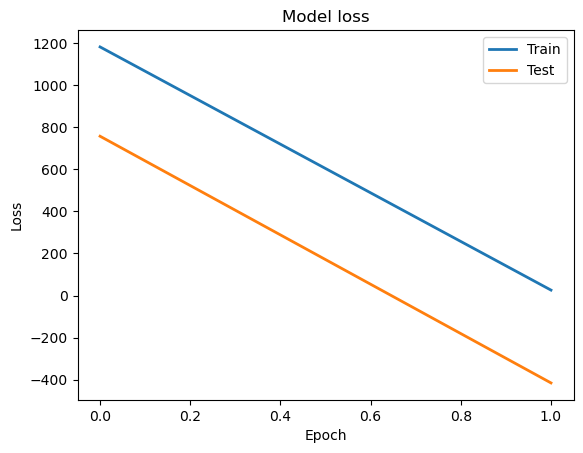

In [55]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('trabalho_11.png', bbox_inches='tight')

In [52]:
test_x_predictions = autoencoder.predict([test_data,np.ones(len(test_data))])
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'Class': test_labels})

/home/thiago/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


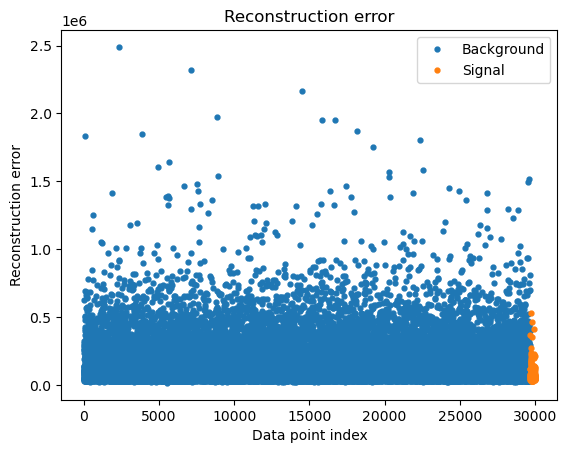

In [53]:
groups = error_df.groupby('Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Signal" if name == 1 else "Background")
ax.legend()
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [9]:
from datetime import datetime

def time_stamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H.%M.%S")
    return timestampStr

with open('readme.txt', 'w') as f:
    f.write('Iteration 1 ==> ' + time_stamp())

with open('readme.txt', 'a') as f:
    f.writelines('\n    . 1 of 300 combinations at ' + time_stamp())

In [10]:
with open('readme.txt', 'r') as f:
    lines = f.readlines()

with open('readme.txt', 'w') as f:
    for line in lines:
        if line.strip('\n') != lines[-1]:
            f.write(line)
            f.writelines('    . 1 of 301 combinations at ' + time_stamp())